In [1]:
import tarfile
import torch
import torchvision.transforms as T
import json
import os
import csv
import pandas as pd
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import detection
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
torch.cuda.empty_cache()

# Handle the dataset

### extract the compressed data

In [ ]:
# Extract the .tar.gz file
with tarfile.open('nycu-hw2-data.tar.gz', 'r:gz') as archive:
    archive.extractall()  # The folder where the contents will be extracted

### generate ground truth csv file

In [2]:
def coco_to_csv(json_path, output_csv):
    # Load the COCO JSON file
    with open(json_path, "r") as f:
        coco_data = json.load(f)

    # Extract image file names
    images = {img["id"]: img["file_name"] for img in coco_data["images"]}

    # Extract category ID to digit mapping
    categories = {cat["id"]: str(cat["name"])
                  for cat in coco_data["categories"]}

    # Dictionary to store image_id -> detected digits & bounding boxes
    image_data = {}

    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        digit = categories[category_id]  # Convert category ID to digit label
        x_min, y_min, width, height = ann["bbox"]  # Extract bounding box

        if image_id not in image_data:
            image_data[image_id] = {"file_name": images[image_id],
                                    "digits": []}

        # Store digit with its bounding box x_min
        image_data[image_id]["digits"].append((x_min, digit))

    # Convert to CSV format
    rows = []
    for image_id, data in image_data.items():
        # Sort digits from left to right based on x_min
        sorted_digits = sorted(data["digits"], key=lambda x: x[0])
        # Concatenate digits
        digit_sequence = "".join(d[1] for d in sorted_digits)

        rows.append([image_id, digit_sequence])

    # Save as CSV
    df = pd.DataFrame(rows, columns=["image_id", "label"])
    df.to_csv(output_csv, index=False)
    print(f"CSV saved to {output_csv}")


# Path to your COCO format JSON file
coco_json_path = "./nycu-hw2-data/valid.json"
output_csv_path = "./nycu-hw2-data/valid_label.csv"
coco_to_csv(coco_json_path, output_csv_path)


CSV saved to ./nycu-hw2-data/valid_label.csv


### load data

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, json_path, image_dir, transforms=None, is_test=False):
        with open(json_path, 'r') as f:
            data = json.load(f)
        # print(data.keys())

        self.image_dir = image_dir
        self.transforms = transforms
        self.image_info = {img['id']: img['file_name']
                           for img in data['images']}
        self.is_test = is_test

        # Only parse annotations if it's not the test set
        if not self.is_test:
            self.annotations = self._parse_annotations(data['annotations'])
        else:
            self.annotations = None

    def _parse_annotations(self, annotations):
        ann_dict = {}
        for ann in annotations:
            img_id = ann['image_id']
            bbox = ann['bbox']  # COCO format: [x_min, y_min, w, h]
            x_min, y_min, w, h = bbox
            x_max, y_max = x_min + w, y_min + h
            if img_id not in ann_dict:
                ann_dict[img_id] = {'boxes': [], 'labels': []}
            ann_dict[img_id]['boxes'].append([x_min, y_min, x_max, y_max])
            # Category IDs start from 1
            ann_dict[img_id]['labels'].append(ann['category_id'])
        return ann_dict

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        img_id = list(self.image_info.keys())[idx]
        img_path = os.path.join(self.image_dir, self.image_info[img_id])
        image = Image.open(img_path).convert("RGB")
        if self.is_test:
            # For testing, return an empty target
            target = {'boxes': torch.empty((0, 4), dtype=torch.float32),
                      'labels': torch.empty(0, dtype=torch.int64),
                      'image_id': torch.tensor([img_id], dtype=torch.int64)
                      }
        else:
            # For training or validation, return the annotations
            target = self.annotations.get(img_id, {'boxes': [], 'labels': []})
            target['boxes'] = torch.tensor(target['boxes'],
                                           dtype=torch.float32)
            target['labels'] = torch.tensor(target['labels'],
                                            dtype=torch.int64)
            target['image_id'] = torch.tensor([img_id], dtype=torch.int64)
        if self.transforms:
            image = self.transforms(image)
        return image, target


# Define transformations
train_transform = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

valid_transform = T.Compose([
    T.ToTensor()
])

data_dir = './nycu-hw2-data'

# Load the training and validation datasets
train_dataset = DigitDataset(
    json_path=os.path.join(data_dir, 'train.json'),
    image_dir=os.path.join(data_dir, 'train'),
    transforms=train_transform,
    is_test=False
)
val_dataset = DigitDataset(
    json_path=os.path.join(data_dir, 'valid.json'),
    image_dir=os.path.join(data_dir, 'valid'),
    transforms=valid_transform,
    is_test=False
)


def seed_worker(worker_id):
    """Seed each worker deterministically for reproducibility."""
    seed = torch.initial_seed() % 2**32  # Ensure seed is within valid range
    np.random.seed(seed)
    random.seed(seed)


# Set global seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the seed for each worker
g = torch.Generator()
g.manual_seed(seed)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)), num_workers=8,
                          generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)), num_workers=8)

for images, targets in train_loader:
    print(targets)
    print(images[0].shape)
    break

({'boxes': tensor([[ 56.,  16., 108.,  88.],
        [112.,   3., 155.,  75.]]), 'labels': tensor([4, 5]), 'image_id': tensor([25541])}, {'boxes': tensor([[ 74.,  24., 102.,  64.],
        [102.,  28., 124.,  68.]]), 'labels': tensor([3, 2]), 'image_id': tensor([7728])}, {'boxes': tensor([[51., 15., 67., 54.]]), 'labels': tensor([5]), 'image_id': tensor([4809])}, {'boxes': tensor([[37., 11., 46., 27.],
        [46., 10., 54., 26.],
        [56.,  8., 63., 24.]]), 'labels': tensor([5, 5, 9]), 'image_id': tensor([24444])}, {'boxes': tensor([[ 76.,  11., 113.,  97.]]), 'labels': tensor([9]), 'image_id': tensor([27247])}, {'boxes': tensor([[26., 22., 33., 42.],
        [35., 16., 43., 36.],
        [45., 11., 51., 31.]]), 'labels': tensor([4, 1, 2]), 'image_id': tensor([10628])}, {'boxes': tensor([[146.,  31., 179.,  83.],
        [166.,  27., 197.,  79.],
        [186.,  29., 213.,  81.],
        [206.,  33., 239.,  85.]]), 'labels': tensor([2, 5, 4, 7]), 'image_id': tensor([26493])}, {'b

# Training

In [ ]:
def get_model(num_classes=11):  # 10 digits + background
    # use VGG16 as the backbone
    '''
    # Load pretrained VGG16 model
    VGG16 = torchvision.models.vgg16(weights="DEFAULT")

    # Extract features from VGG16
    # (use 'features.42' as the last conv layer output)
    backbone = create_feature_extractor(
        VGG16, return_nodes={'features.29': '1'}
    )
    backbone.out_channels = 512 # VGG16 has 512 output channels

    # Define an Anchor Generator for a single feature map level

    anchor_generator = AnchorGenerator(
        # Extra tuple to match feature map count
        sizes=((8, 16, 32, 64, 128),),
         # Extra tuple to match feature map count
        aspect_ratios=((0.5, 1.0, 2.0, 3.0),)
    )

    # Define Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,  # Pass the anchor generator
        # box_roi_pool=roi_pooler,  # Pass the RoI pooler
    )
    '''

    # use ResNet50 as the backbone
    model = detection.fasterrcnn_resnet50_fpn_v2(pretrained=True,
                                                 nms_thresh=0.4)
    # freeze the backbone layers
    '''
    for name, param in model.backbone.body.named_parameters():
        if name.startswith("layer1"):
            param.requires_grad = False
    '''
    # change the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Move model to GPU if available
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

### train process

In [ ]:
def evaluate_mAP_acc(model, dataloader, coco_gt_path, csv_gt_path):
    model.eval()
    coco_gt = COCO(coco_gt_path)  # Load ground truth annotations
    coco_results = []
    image_results = {}  # Dictionary to store results for each image
    output_csv = "valid_label_pred.csv"  # Output CSV file path
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img_idx, output in enumerate(outputs):
                image_id = targets[img_idx]["image_id"].item()
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                # Apply confidence threshold
                confidence_threshold = 0.7
                keep = scores >= confidence_threshold
                boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

                '''
                if len(labels) == 0:  # No digits detected
                    image_results[image_id] = "-1"
                    continue  # Skip to next image
                '''

                if len(boxes) == 0:  # No digits detected
                    image_results[image_id] = "-1"
                    continue

                # Convert boxes from [x_min, y_min, x_max, y_max]
                # to COCO format [x, y, w, h]
                if boxes.shape[0] > 0:
                    boxes[:, 2:] -= boxes[:, :2]  # Convert to [x, y, w, h]

                for box, score, label in zip(boxes, scores, labels):
                    coco_results.append({
                        "image_id": int(image_id),
                        "category_id": int(label),  # Category IDs start from 1
                        "bbox": box.tolist(),
                        "score": float(score)
                    })

                # Prepare data for CSV (sorting bboxes by x_min)
                # Sort by x_min (left to right)
                sorted_indices = np.argsort(boxes[:, 0])
                sorted_labels = [str(labels[i]-1) for i in sorted_indices]
                detected_number = "".join(sorted_labels)  # Concatenate digits

                # Store result per image
                image_results[image_id] = detected_number

    # Save results in COCO format
    with open("coco_predictions.json", "w") as f:
        json.dump(coco_results, f)

        # Save predictions in CSV format
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "pred_label"])  # CSV header
        for image_id in sorted(image_results.keys()):
            writer.writerow([image_id, image_results[image_id]])

    # Load COCO results and compute mAP
    coco_dt = coco_gt.loadRes("coco_predictions.json")
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    mAP = coco_eval.stats[0]  # AP@[0.5:0.95]
    print(f"mAP: {mAP}\n")

    # compare the csv file with the ground truth
    gt_df = pd.read_csv(csv_gt_path)
    pred_df = pd.read_csv(output_csv)
    gt_df = gt_df.set_index("image_id")
    pred_df = pred_df.set_index("image_id")
    gt_df = gt_df.sort_index()
    pred_df = pred_df.sort_index()
    gt_df = gt_df.astype(str)
    pred_df = pred_df.astype(str)
    gt_df["pred_label"] = pred_df["pred_label"]
    gt_df["correct"] = gt_df["pred_label"] == gt_df["label"]
    gt_df["correct"] = gt_df["correct"].astype(int)
    gt_df["correct"] = gt_df["correct"].replace(0, "False")
    gt_df["correct"] = gt_df["correct"].replace(1, "True")
    gt_df.to_csv("compare.csv")
    # Print the accuracy
    correct_count = gt_df["correct"].value_counts().get("True", 0)
    total_count = len(gt_df)
    accuracy = correct_count / total_count
    print(f"Accuracy: {accuracy:.4%}")

    return mAP, accuracy


def train(model, optimizer, scheduler, epochs=10):
    best_mAP = 0.0
    best_loss = 10.0
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device)
                        for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()  # Accumulate loss
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.5f}")
        scheduler.step()
        torch.save(model.state_dict(),
                   f"./checkpoint/fasterRCNN_resnet50v2_epoch={epoch+1}.pth")

        # validation data evaluation
        print("Validation data evaluation: ")
        # val_acc = evaluate_accuracy(model, val_loader)
        path_val_json = os.path.join(data_dir, 'valid.json')
        path_val_csv = os.path.join(data_dir, 'valid_label.csv')
        val_mAP, val_acc = evaluate_mAP_acc(model, val_loader,
                                            path_val_json, path_val_csv)

        flag = False

        if val_mAP > best_mAP:
            best_mAP = val_mAP
            with open("record.csv", mode="a", newline="") as f:
                writer = csv.writer(f)
                curr_epoch = epoch + 1
                writer.writerow([curr_epoch, avg_loss, val_mAP, val_acc])
                flag = True
            print("Model saved!")

        if avg_loss < best_loss:
            best_loss = avg_loss
            if not flag:
                with open("record.csv", mode="a", newline="") as f:
                    writer = csv.writer(f)
                    curr_epoch = epoch + 1
                    writer.writerow([curr_epoch, avg_loss, val_mAP, val_acc])
                flag = True
            print("Model saved!")

        if val_acc > best_acc:
            best_acc = val_acc
            if not flag:
                with open("record.csv", mode="a", newline="") as f:
                    writer = csv.writer(f)
                    curr_epoch = epoch + 1
                    writer.writerow([curr_epoch, avg_loss, val_mAP, val_acc])
                flag = True
            print("Model saved!")


In [ ]:
model = get_model()
model.to(device)
# load the pre-trained model
# model.load_state_dict(torch.load('./checkpoint/fasterRCNN_resnet50_epoch=2_freeze1_nms=0.4_bs=16.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001,
                              weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
train(model, optimizer, scheduler, epochs=6)

/home/kwchiu/anaconda3/envs/PRDL/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kwchiu/anaconda3/envs/PRDL/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1879/1879 [36:42<00:00,  1.17s/it]


Epoch 1, Loss: 0.26966
Validation data evaluation: 
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.68s).
Accumulating evaluation results...
DONE (t=0.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 1879/1879 [36:51<00:00,  1.18s/it]


Epoch 2, Loss: 0.23141
Validation data evaluation: 
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.82s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 1879/1879 [36:52<00:00,  1.18s/it]


Epoch 3, Loss: 0.21720
Validation data evaluation: 
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 1879/1879 [36:37<00:00,  1.17s/it]


Epoch 4, Loss: 0.21092
Validation data evaluation: 
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 1879/1879 [36:38<00:00,  1.17s/it]


Epoch 5, Loss: 0.20158
Validation data evaluation: 
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


Loading and preparing results...
DONE (t=0.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

100%|██████████| 1879/1879 [36:39<00:00,  1.17s/it]


Epoch 6, Loss: 0.18993
Validation data evaluation: 
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.591
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

# Testing

In [ ]:
class digit_dataset_test(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(os.listdir(self.image_dir))

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f"{idx+1}.png")
        image_filename = os.path.basename(image_path)
        image = Image.open(image_path).convert("RGB")  # Ensure RGB format

        if self.transforms:
            image = self.transforms(image)

        return image, image_filename


# Define transformations
test_transform = T.Compose([
    T.ToTensor(),
])

# Create the test dataset
test_dataset = digit_dataset_test(
    image_dir=os.path.join(data_dir, 'test'),
    transforms=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
def save_predictions(model, dataloader, output_json="pred.json",
                     output_csv="pred.csv"):
    model.eval()
    coco_results = []
    image_results = {}

    with torch.no_grad():
        # Assuming image_ids contain image indices
        for images, image_ids in tqdm(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img_idx, output in enumerate(outputs):
                # Extract image ID from filename
                image_id = int(image_ids[img_idx].split(".")[0])
                # [x_min, y_min, x_max, y_max]
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                confidence_threshold = 0.7
                boxes = boxes[scores >= confidence_threshold]
                labels = labels[scores >= confidence_threshold]
                scores = scores[scores >= confidence_threshold]

                if len(labels) == 0:  # No digits detected
                    image_results[image_id] = "-1"
                    continue  # Skip to next image

                # Convert boxes from [x_min, y_min, x_max, y_max]
                # → COCO format [x, y, w, h]
                boxes[:, 2:] -= boxes[:, :2]

                # Store for JSON output
                for box, score, label in zip(boxes, scores, labels):
                    coco_results.append({
                        "image_id": image_id,
                        "bbox": box.tolist(),
                        "score": float(score),
                        "category_id": int(label)
                    })

                # Prepare data for CSV (sorting bboxes by x_min)
                # Sort by x_min (left to right)
                sorted_indices = np.argsort(boxes[:, 0])
                sorted_labels = [str(labels[i]-1) for i in sorted_indices]
                detected_number = "".join(sorted_labels)  # Concatenate digits

                # Store result per image
                image_results[image_id] = detected_number

    # Save predictions in COCO JSON format
    with open(output_json, "w") as f:
        json.dump(coco_results, f)

    # Save predictions in CSV format
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "pred_label"])  # CSV header
        for image_id in sorted(image_results.keys()):
            writer.writerow([image_id, image_results[image_id]])

    print(f"Saved COCO JSON results to {output_json}")
    print(f"Saved CSV results to {output_csv}")


model = get_model()
# load the pre-trained model
model.load_state_dict(
    torch.load('./checkpoint/fasterRCNN_resnet50v2_epoch=5_pure.pth'))
save_predictions(model, test_loader)


/tmp/ipykernel_2479037/2121337052.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoint/fasterRCNN_resnet50v2_epoch=5_pure.pth'

Saved COCO JSON results to pred.json
Saved CSV results to pred.csv


### Test one image

/tmp/ipykernel_1093928/3715749031.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoint/fasterRCNN_resnet50_epoch=7_freeze1_nms

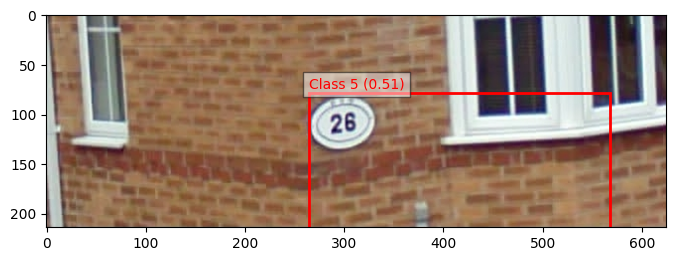

In [ ]:
# Define preprocessing transforms (same as used during training)
transform = transforms.Compose([
    T.ToTensor()
])


def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
    return transform(image)  # Do NOT add .unsqueeze(0) here


def test_single_image(model, image_path, confidence_threshold=0.5):
    image = preprocess_image(image_path).to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        output = model([image])[0]  # Faster R-CNN expects a list of images

    # Extract predictions
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    labels = output["labels"].cpu().numpy()

    # Apply confidence threshold
    keep = scores > confidence_threshold
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # Plot the image with predictions
    fig, ax = plt.subplots(1, figsize=(8, 6))
    img = Image.open(image_path)
    ax.imshow(img)

    for box, score, label in zip(boxes, scores, labels):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                 edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Class {label} ({score:.2f})", color="red",
                fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

    plt.show()


# Test on an image
model = get_model()
path = './checkpoint/fasterRCNN_resnet50_epoch=7_freeze1_nms=0.4_anc16.pth'
model.load_state_dict(torch.load(path))
test_single_image(model, "./nycu-hw2-data/test/60.png",
                  confidence_threshold=0.5)



### plot the learning curve

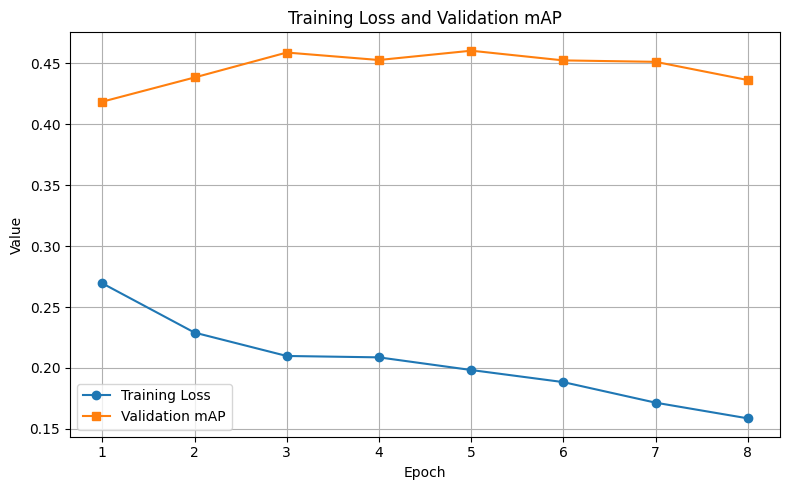

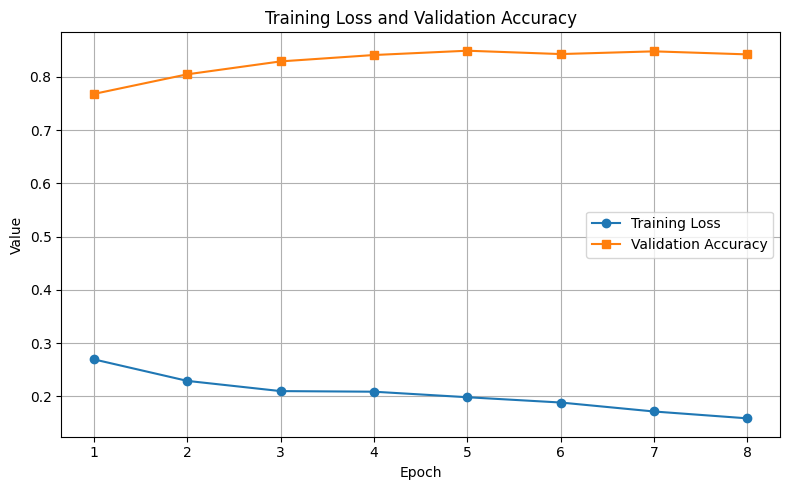

In [ ]:
training_losses = [0.269424895011979, 0.2290221017970247,
                   0.20984160032533725, 0.20870534507453664,
                   0.1983316453563336, 0.18839998322401738,
                   0.17154505570925188, 0.1586830179509868]
val_mAPs = [0.41842399032253824, 0.4382824674029635,
            0.45874131259780315, 0.45261673647979245,
            0.4602394654519233, 0.45229268183860605,
            0.4511241469319957, 0.43617057478749616]
val_accuracies = [0.7679640718562875, 0.8047904191616766,
                  0.8290419161676646, 0.8410179640718562,
                  0.8491017964071856, 0.842814371257485,
                  0.8479041916167664, 0.8422155688622754]
epochs = list(range(1, len(training_losses) + 1))


# === Plot 1: Training Loss vs. Validation mAP ===
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_mAPs, label='Validation mAP', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation mAP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_vs_map.png')  # Optional: save the plot
plt.show()

# === Plot 2: Training Loss vs. Validation Accuracy ===
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_vs_accuracy.png')  # Optional: save the plot
plt.show()
